## 🏎️ Araba Yarışı

---

Bu projede, Gymnasium'dan [Car Racing ortamı](https://gymnasium.farama.org/environments/box2d/car_racing/) ile çalışacaksınız. Görev, prosedürel olarak oluşturulan bir pistte arabayla sürüş yaparak, yolda kalırken turları verimli bir şekilde tamamlamaktır.

İki tür pekiştirmeli öğrenme ajanı eğiteceksiniz: bir **DQN ajanı** ve bir **PPO ajanı**.

---

### 🚧 Bu Projeyi Farklı Kılan Nedir?

**CliffWalking** gibi **ayrık eylem uzayları** kullanan önceki ortamların aksine, Car Racing ortamı **sürekli eylem uzayı** kullanır.

- Ajanlar şunları kontrol etmeli:
  - **Direksiyon** (sol/sağ)
  - **Hızlanma** (gaz)
  - **Fren yapma**

Bu şu anlama gelir:
- ❌ DQN, ince ayarlı sürekli kontrolde zorlanır  
- ✅ PPO çok daha uygun, çünkü sürekli politikaları doğrudan öğrenebilir

🧠 Bu proje, **Politika Gradyanı yöntemleri** olan PPO'nun neden sürekli kontrol problemlerinde tercih edildiğini ve DQN'u yanlış ortama zorladığınızda ne olduğunu anlamanıza yardımcı olacak.

---
Bu proje için ihtiyaç duyacağımız tüm paketleri içe aktararak başlayalım:

In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt

import gymnasium as gym
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3 import DQN
from stable_baselines3 import PPO
from stable_baselines3.common.callbacks import BaseCallback

---
### Bölüm 1 : CarRacing üzerinde DQN

Bu bölümde, şimdiye kadar öğrendiğiniz her şeyi uygulayacaksınız — ancak bu sefer Gymnasium'dan `CarRacing-v3` ortamı üzerinde.

#### 🧠 İlginç olan ne?  
→ `CarRacing-v3` **sürekli** eylem uzayına sahip.  
→ DQN sadece **ayrık** eylemlerle çalışır.  

Bu görev DQN'un temel bir sınırını vurgular.

#### 📝 İzlenecek Adımlar:

1. 🚗 Ortamı Yükle: Ortamı yüklemek için `gym.make('CarRacing-v3')` kullan.
2. 🧩 DummyVecEnv ile Sar.
3. ⚙️ DQN Modelini Başlat.
4. 🪵 EpisodeRewardLogger Kullan:
    - Her bölümün sonunda ödülleri kaydetmek için aşağıda sağlanan özel geri çağırma.
    - `.learn()` çağrılırken geri çağırma olarak geçirin.
5. ⏱️ 10.000 Zaman Adımı için Eğit

#### ⚠️ Ne Olur?

```python
ValueError: DQN policies can only be used with environments that have a discrete action space. Your action space is of type Box.
```

Bu hatayı gördüğünüzde, bir sonraki bölüme geçmeye hazırsınız!

In [2]:
# Define a custom callback to log rewards at the end of each episode.
class EpisodeRewardLogger(BaseCallback):
    def __init__(self, verbose=0):
        super(EpisodeRewardLogger, self).__init__(verbose)
        # List to store the total rewards for each episode.
        self.episode_rewards = []
        # Variable to accumulate rewards for the current episode.
        self.episode_reward = 0

    # This method is called after every step taken in the environment.
    def _on_step(self) -> bool:
        # Add the reward from the current step to the episode reward accumulator.
        self.episode_reward += self.locals['rewards'][0]

        # Check if the episode is done (i.e., the environment has reached a terminal state).
        if self.locals['dones'][0]:
            # If the episode is done, append the accumulated reward to the episode_rewards list.
            self.episode_rewards.append(self.episode_reward)
            # Reset the episode reward accumulator to zero for the next episode.
            self.episode_reward = 0

        # Return True to continue training, False would stop the training.
        return True

In [3]:
env = gym.make('CarRacing-v3', render_mode=None)

env = DummyVecEnv([lambda: env])  

model = DQN('MlpPolicy', env, verbose=1)
timesteps = 10000
dqn_episode_reward_logger = EpisodeRewardLogger()

start_time = time.time()

model.learn(total_timesteps=timesteps, callback=dqn_episode_reward_logger)

end_time = time.time()

dqn_training_time = end_time - start_time

model_path = "dqn_car_racing_model"

model.save(model_path)

print("Model trained and saved to", model_path)

/Users/dilay/.pyenv/versions/reinforcement-env/lib/python3.12/site-packages/pygame/pkgdata.py:25: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import resource_stream, resource_exists


Using cpu device
Wrapping the env in a VecTransposeImage.


AssertionError: The algorithm only supports (<class 'gymnasium.spaces.discrete.Discrete'>,) as action spaces but Box([-1.  0.  0.], 1.0, (3,), float32) was provided

### ❓ Bu neden hata veriyor?

- → **DQN** **ayrık eylem kümesi** gerektirir — *sol*, *sağ*, *yukarı*, *aşağı* gibi.  
- → **CarRacing** **sürekli eylem uzayı** kullanır — *direksiyon*, *hızlanma* ve *frenleme* için gerçel değerlerle.

📉 Bu yüzden **DQN bu ortamda çalışmaz** — sürekli kontrol görevleri için inşa edilmemiş.

---
### 🧠 Bölüm 2: Araba Yarışında Politika Gradyanı

Bu bölümde, daha önce yaptığınız işlemi tekrarlayacaksınız — ancak bu sefer **Politika Gradyanı yöntemi** kullanarak:  
Stable Baselines3'ten `MlpPolicy` ile `PPO` modeli.

#### 📝 İzlenecek Adımlar:

1. 🚗 Ortamı Yükle: Ortamı yüklemek için `gym.make('CarRacing-v3')` kullan.
2. 🧩 DummyVecEnv ile Sar.
3. ⚙️ PPO Modelini Başlat.
4. 🪵 EpisodeRewardLogger Kullan:
    - Her bölümün sonunda ödülleri kaydetmek için aşağıda sağlanan özel geri çağırma.
    - `.learn()` çağrılırken geri çağırma olarak geçirin.
5. ⏱️ 10.000 Zaman Adımı için Eğit

In [4]:
env = gym.make('CarRacing-v3', render_mode=None)
env = DummyVecEnv([lambda: env]) 


model = PPO('MlpPolicy', env, verbose=1)
timesteps = 10000
pg_episode_reward_logger = EpisodeRewardLogger()
start_time = time.time()
model.learn(total_timesteps=timesteps, callback=pg_episode_reward_logger)
end_time = time.time()

pg_training_time = end_time - start_time

model_path = "ppo_lunar_lander_model"

model.save(model_path)

print("Model trained and saved to", model_path)

Using cpu device
Wrapping the env in a VecTransposeImage.
-----------------------------
| time/              |      |
|    fps             | 238  |
|    iterations      | 1    |
|    time_elapsed    | 8    |
|    total_timesteps | 2048 |
-----------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 201         |
|    iterations           | 2           |
|    time_elapsed         | 20          |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.005932478 |
|    clip_fraction        | 0.0788      |
|    clip_range           | 0.2         |
|    entropy_loss         | -4.25       |
|    explained_variance   | 0.00887     |
|    learning_rate        | 0.0003      |
|    loss                 | 0.488       |
|    n_updates            | 10          |
|    policy_gradient_loss | -0.00439    |
|    std                  | 0.998       |
|    value_loss   

👉 Eğitim ne kadar sürdü?

In [5]:
print(f"Training completed in {pg_training_time:.2f} seconds")

Training completed in 58.56 seconds


👉 Ödülleri zaman içinde çizin.

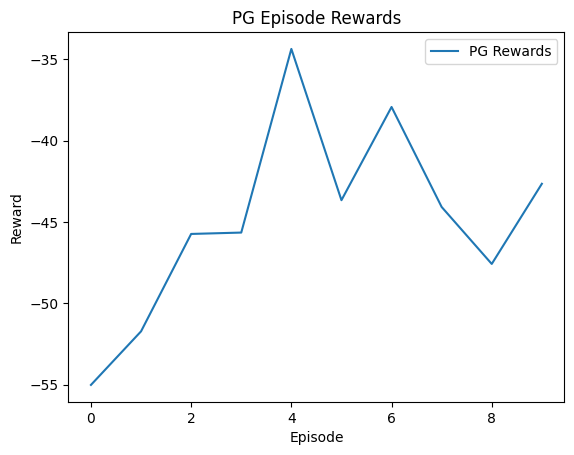

In [6]:
plt.plot(pg_episode_reward_logger.episode_rewards, label='PG Rewards')
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title('PG Episode Rewards')
plt.legend()
plt.show()

#### 📊 Politika Gradyanı Eğitim Günlüğü Metriklerini Anlama

PPO gibi algoritmalarla eğitim yaparken, çeşitli günlük metrikleri performansı ve eğitim kararlılığını takip etmenize yardımcı olur.

#### ⏱️ Zamanla İlgili Metrikler

- **fps** → Saniye başına kare — model ne kadar hızlı eğitiliyor. Yüksek = daha iyi.  
- **iterations** → Tamamlanan parametre güncelleme döngüsü sayısı.  
- **time_elapsed** → Eğitimin başlamasından bu yana geçen toplam süre (saniye).  
- **total_timesteps** → Ajan tarafından deneyimlenen toplam ortam adımı sayısı.

#### 🧠 Eğitim Süreci Metrikleri

- **approx_kl** → Bir güncellemeden sonra politikanın ne kadar değiştiği.  
  - Düşük = daha kararlı öğrenme.  
- **clip_fraction** → PPO'nun güncelleme kırpmasının ne sıklıkta uygulandığı.  
- **clip_range** → Politika güncellemelerini kırpmak için kullanılan aralık (ani değişiklikleri önler).  
- **entropy_loss** → Eylem seçimindeki rastgeleliği ölçer.  
  - Yüksek = daha fazla keşif.  
- **explained_variance** → Değer tahminlerinin gerçek getirilerle ne kadar eşleştiği.  
  - 1'e yakın = daha iyi.  
- **learning_rate** → Ağırlık güncellemelerinin boyutunu kontrol eder.  
- **loss** → Genel eğitim kaybı — iyileşmeyi takip etmeye yardımcı olur.  
- **n_updates** → Toplam model ağırlığı güncellemesi sayısı.  
- **policy_gradient_loss** → Politikanın ne kadar iyileştiğini gösterir.  
- **value_loss** → Değer fonksiyonu tahminlerinin ne kadar doğru olduğunu ölçer.

#### 🔍 Bu Metrikleri Nasıl Yorumlarız

- **Yüksek `entropy_loss`** → Ajan daha fazla keşfediyor (çok rastgele olabilir).  
- **Düşük `explained_variance`** → Değer tahminleri yanlış.  
- **Azalan `loss`** → Zaman içinde etkili öğrenme olduğunu gösterir.

---

### 🧠 Politika Gradyanı Neden CarRacing için İdeal

CarRacing pürüzsüz ve hassas kontrol gerektirir — bu da **Politika Gradyanı yöntemleri** olan **PPO**'yu mükemmel uyum haline getirir.

#### 1. 🎯 Sürekli Eylemler için Tasarlandı  
- PPO **gerçek değerli eylemleri** doğrudan işler.  
- CarRacing'de, ajan sadece sol veya sağı seçmek değil, *ne kadar direksiyon kırılacağını*, *ne kadar sert fren yapılacağını* ve *ne kadar gaz verileceğini* seçmesi gerekir.

#### 2. 🧠 Politikayı Doğrudan Öğrenir  
- Eylemlerin değerini tahmin eden DQN'un aksine, PPO *nasıl* davranacağını öğrenir.  
- Bu, yüksek hızlı sürüş ortamlarında kritik olan **daha esnek ve uyarlanabilir davranışlara** olanak tanır.

#### 3. 🪶 Pürüzsüz ve Hassas Kontrol  
- PPO **ince ayarlı kararları** destekler — sürüş görevlerinde gereken ince ayarlamalar için mükemmel.  
- Artık ani, hep ya da hiç hareketler yok.

---

### ❌ DQN Neden Burada İyi Bir Uyum Değil

- **DQN ayrık eylem uzayı gerektirir** (ör. *yukarı*, *aşağı*, *sol*, *sağ*).  
- CarRacing **sürekli eylem uzayı** kullanır — eylemlerin gerçel sayılar olduğu.

DQN kullanmak için, direksiyon/fren/gaz kombinasyonlarının tamamını **ayrıklaştırmanız** gerekir:  
🧱 Verimsiz ve nadiren etkili olan bir geçici çözüm.

---

### ⚖️ Özet: Politika Gradyanının Parladığı Yer Burası

| Yöntem           | CarRacing'deki Gücü                                    |
|------------------|-----------------------------------------------------------|
| 🧠 Politika Gradyanı | Sürekli eylemleri doğrudan öğrenir — ayrıklaştırma gerekmez. |
| ❌ DQN             | Sürekli eylemler için inşa edilmemiş — uyum sağlamakta zorlanır.         |